# CNN for MNIST Dataset

##### Ref : https://github.com/c1mone/Tensorflow-101/blob/master/notebooks/2_MNIST_Convolutional_Network.ipynb

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\pc\Anaconda3\envs\tf110\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Download MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### Implement CNN

In [3]:
# Function for weight initialization
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape) # Positive value to avoid deal Relu
    return tf.Variable(initial)

In [4]:
# Function for CNN layer
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')

In [5]:
# Placeholder for input / label data
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

# Reshape for CNN input
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [6]:
# Layer 1
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [7]:
# Layer 2
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [8]:
# Layer 3 -- Full connect
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [9]:
# Add dropout layer to avoid overfitting
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [10]:
# Layer 4 -- Final output layer (Softmax)
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [11]:
# Loss function (Cross-entropy)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_conv, labels=y_))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
# Optimizer (Adam)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [13]:
# Add node for evaluation
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
# Initialize 
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

In [16]:
# Train
epoch, batch = 200, 50

for i in range(epoch):
    batch_xs, batch_ys  = mnist.train.next_batch(batch)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})

    if i % 20 == 0:
        train_accuracy = sess.run(accuracy, feed_dict={x:batch_xs, y_: batch_ys, keep_prob: 1.0})
        print("step %d, training accuracy %g" % (i, train_accuracy))

step 0, training accuracy 0.86
step 20, training accuracy 0.9
step 40, training accuracy 0.84
step 60, training accuracy 1
step 80, training accuracy 0.9
step 100, training accuracy 0.92
step 120, training accuracy 0.92
step 140, training accuracy 0.94
step 160, training accuracy 0.88
step 180, training accuracy 0.98


In [20]:
# Evaluation
print("test accuracy %g" % sess.run(accuracy, feed_dict={x: mnist.test.images[:1000, :], y_: mnist.test.labels[:1000, :], keep_prob: 1.0}))

test accuracy 0.924


In [23]:
# Function for visualization
def plot_conv_weights(weights, num_filters, input_channel = 0):
    w = sess.run(weights)
    
    num_grids = int(np.ceil(np.sqrt(num_filters)))
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_grids * num_grids:
            img = w[:, :, input_channel, i]
            
            ax.imshow(img, vmin = w_min, vmax=w_max, interpolation = 'nearest', cmap = 'seismic')

def plot_conv_layer(layer, image, num_filters):
    output = sess.run(layer, feed_dict = {x: [image]})
    
    num_grids = int(np.ceil(np.sqrt(num_filters)))
    
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_grids * num_grids:
            img = output[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='gray')

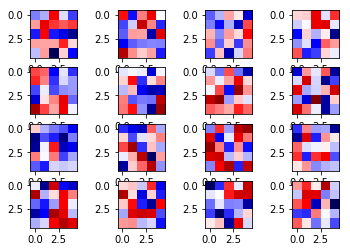

In [24]:
# Visualize convolution filter
plot_conv_weights(W_conv1, 16)

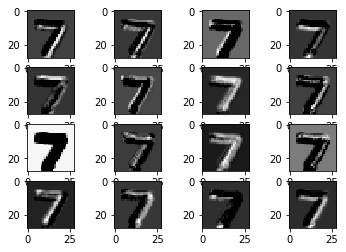

In [27]:
# Visualize activation
image1 = mnist.test.images[0]
plot_conv_layer(h_conv1, image1, 16)